In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.stats import poisson
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import json
from datetime import date, timedelta
import math
np.random.seed(seed=42)
# plt.rcParams['text.usetex'] = True
# plt.rcParams["font.family"] = "Times New Roman"
# sns.set_style("whitegrid", rc={'font.family': 'Times New Roman', 'font.size': 16})
plt.rc('legend',fontsize=16)
plt.rcParams.update({'font.size': 16, 'axes.labelsize': 14, 'axes.titlesize': 14, 'xtick.labelsize': 14, 'ytick.labelsize': 14})
sns.set_style("whitegrid", rc={'font.size': 16})

from constants import LOCATION_CHOOSEN, LOCATION_CHOOSEN_2, OUTPUT_DIR, DATA_CACHE_DIR, OPTIMAL_VALUES_FILE, STRINGENCY_BASED_GDP

In [2]:
data_path = os.path.join(DATA_CACHE_DIR, LOCATION_CHOOSEN + "_merged_data.csv")
if os.path.exists(data_path):
    df = pd.read_csv(data_path)
else:
    df = pd.read_excel("owid-covid-data.xlsx")
    df = df.loc[df['iso_code'] == LOCATION_CHOOSEN]
    df.to_csv(data_path, index=False)

In [3]:
start_date = date(2020, 5, 1)
end_date = date(2022, 11, 1)
# end_date = date(2023, 7, 1)
delta = timedelta(days=1)

worldometers_dates = []
worldometers_total_cases = []
worldometers_total_recovered = []
worldometers_active_cases = []

while start_date <= end_date:
    date_str = start_date.strftime("%Y%m%d")
    data_path_worldometer = os.path.join(DATA_CACHE_DIR, "worldometer", date_str + ".csv")
    if os.path.exists(data_path_worldometer):
        worldometer_df = pd.read_csv(data_path_worldometer)
        worldometer_df.columns = ['country' if col.startswith('Country') else col for col in worldometer_df.columns]
        worldometer_df.columns = worldometer_df.columns.str.lower().str.replace(' ', '')
        date_data = ""
        total_cases = 0
        total_recovered = 0
        worldometer_df_specified_location = worldometer_df.loc[(worldometer_df["country"].str.lower() == LOCATION_CHOOSEN_2.lower())]
        date_data = date_str[:4] + "-" + date_str[4:6] + "-" + date_str[6:]
        total_cases = 0.0 if math.isnan(worldometer_df_specified_location["totalcases"].item()) else worldometer_df_specified_location["totalcases"].item()
        active_cases = 0.0 if math.isnan(worldometer_df_specified_location["activecases"].item()) else worldometer_df_specified_location["activecases"].item()
        total_recovered = 0.0 if math.isnan(worldometer_df_specified_location["totalrecovered"].item()) else worldometer_df_specified_location["totalrecovered"].item()
        # print(date_data, total_cases, total_recovered, type(total_recovered), math.isnan(total_recovered))
        worldometers_dates.append(date_data)
        worldometers_total_cases.append(total_cases)
        worldometers_total_recovered.append(total_recovered)
        worldometers_active_cases.append(active_cases)
    else:
        print(data_path_worldometer, "DOES NOT EXIST -- COLLECT DATA MANUALLY")
    start_date += delta

In [4]:
worldometer_df = pd.DataFrame({"date": worldometers_dates, "total_cases_worldometer": worldometers_total_cases, "total_recovered_worldometer": worldometers_total_recovered, "active_cases_worldometer": worldometers_active_cases})
result = pd.merge(df, worldometer_df, on="date")
df = result

df['date'] = pd.to_datetime(df['date'])

In [5]:
df

,date,stringency_index,total_cases,total_deaths,total_vaccinations,population,people_fully_vaccinated,gdp_normalized,gdp_normalized_modelled,total_cases_worldometer,total_recovered_worldometer,active_cases_worldometer
0,2020-05-01,96.30,35043.0,1147.0,0.000000e+00,1.417173e+09,7668.0,83.905433,88.264410,35043,9068.0,24821.0
1,2020-05-02,96.30,37336.0,1218.0,0.000000e+00,1.417173e+09,7668.0,84.041307,88.264410,37257,10007.0,26027.0
2,2020-05-03,96.30,39980.0,1301.0,0.000000e+00,1.417173e+09,7668.0,84.177181,88.264410,42505,11775.0,29339.0
3,2020-05-04,81.94,42533.0,1373.0,0.000000e+00,1.417173e+09,7668.0,84.313055,94.904432,42670,11782.0,29493.0
4,2020-05-05,81.94,46433.0,1568.0,0.000000e+00,1.417173e+09,7668.0,84.448930,94.904432,49400,14142.0,33565.0
...,...,...,...,...,...,...,...,...,...,...,...,...
910,2022-10-28,31.48,44649088.0,528999.0,2.196044e+09,1.417173e+09,950032740.0,99.893668,99.063148,44649088,44100691.0,19398.0
911,2022-10-29,31.48,44650662.0,529008.0,2.196215e+09,1.417173e+09,950066782.0,99.898210,99.063148,44650714,44102852.0,18854.0
912,2022-10-30,31.48,44652266.0,529016.0,2.196336e+09,1.417173e+09,950090439.0,99.902753,99.063148,44652266,44104933.0,18317.0
913,2022-10-31,31.48,44653592.0,529024.0,2.196409e+09,1.417173e+09,950104356.5,99.907295,99.063148,44653592,44106656.0,17912.0


In [6]:
# deaths are considered recovered: https://www.kaggle.com/code/lisphilar/covid-19-data-with-sir-model/notebook?scriptVersionId=28560520
# https://lisphilar.github.io/covid19-sir/02_data_engineering.html#1.-Data-cleaning

# df['N'] = df['population']
# df['S'] = df['population'] - df['total_cases_worldometer'] - df['people_fully_vaccinated']
# df['I'] = df['total_cases_worldometer'] - df['total_recovered_worldometer'] - df['total_deaths']
# df['R'] = df['total_recovered_worldometer'] + df['people_fully_vaccinated'] + df['total_deaths']

# without deaths model
df['N'] = df['population']
df['S'] = df['population'] - df['total_cases_worldometer'] - df['people_fully_vaccinated'] - df['total_recovered_worldometer']
df['I'] = df['total_cases_worldometer'] - df['total_recovered_worldometer']
df['R'] = df['total_recovered_worldometer'] + df['people_fully_vaccinated']

2313.0


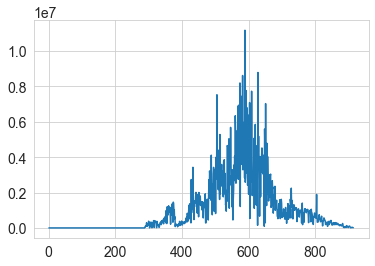

In [7]:
plt.plot( df['people_fully_vaccinated'].diff())
print(min(df['people_fully_vaccinated'].diff()[290:]))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


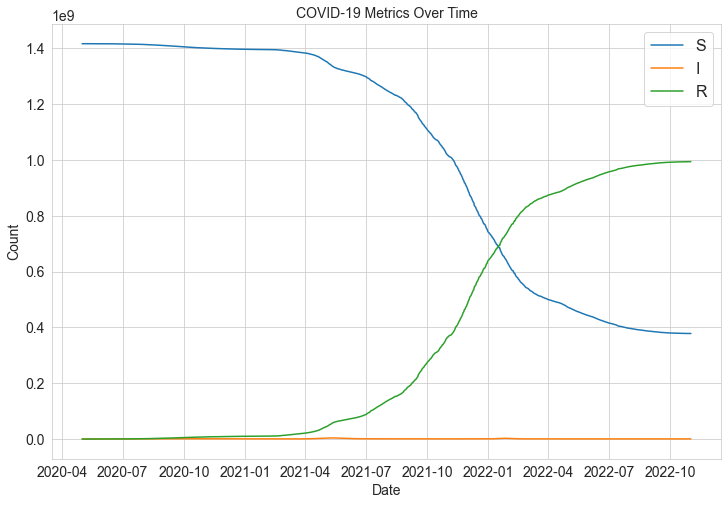

In [8]:
plt.figure(figsize=(12, 8))
plt.plot(df['date'], df['S'], label='S')
plt.plot(df['date'], df['I'], label='I')
plt.plot(df['date'], df['R'], label='R')
plt.title('COVID-19 Metrics Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, "metrics_over_time_" + LOCATION_CHOOSEN + ".eps"))
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


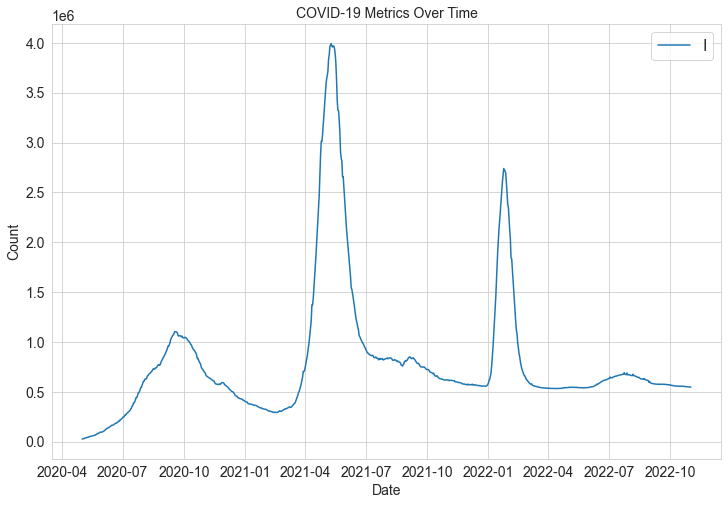

In [9]:
plt.figure(figsize=(12, 8))
plt.plot(df['date'], df['I'], label='I')
plt.title('COVID-19 Metrics Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, "infected_over_time_" + LOCATION_CHOOSEN + ".eps"))
plt.show()

## SIR Model

In [10]:
# def compute_cost(data, predictions):
#     # mse
#     return np.square(data - predictions).mean()

# def compute_cost(data, predictions):
#     # mae
#     return np.abs(data - predictions).mean()

# def compute_cost(data, predictions):
#     # Relative Root Mean Squared Error
#     residual = data - predictions
#     root_mean_squared_error = np.sqrt(np.mean(np.square(residual)))
#     mean_data = np.mean(data)
#     return root_mean_squared_error / mean_data

def compute_cost(data, predictions, delta=1.0):
    # Huber loss
    residual = np.abs(data - predictions)
    condition = residual < delta
    squared_loss = 0.5 * np.square(residual)
    linear_loss = delta * (residual - 0.5 * delta)
    return np.where(condition, squared_loss, linear_loss).mean()

In [11]:
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def integrate_system(params, y0, t, N):
    beta, gamma = params
    result = odeint(deriv, y0, t, args=(N, beta, gamma))
    return result

def objective_function(params, y0, t, N):
    predictions = integrate_system(params, y0, t, N)
    S, I, R = predictions.T
    cost = compute_cost(df['S'], S) + compute_cost(df['I'], I) +  compute_cost(df['R'], R)
    return cost

In [12]:
N = df.loc[min(df.index), ['N']].item()
y0 = df.loc[min(df.index), ['S']].item(), df.loc[min(df.index), ['I']].item() + 1, df.loc[min(df.index), ['R']].item()
initial_guess_for_beta, initial_guess_for_gamma = 0.4, 1/15 
days_difference = (max(df['date']) - min(df['date'])).days
t = np.linspace(0, days_difference, days_difference + 1)

optimal_beta: 0.04208479828695971 optimal_gamma: 0.02388356686032017
optimal_beta/optimal_gamma: 1.7620817917644795


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


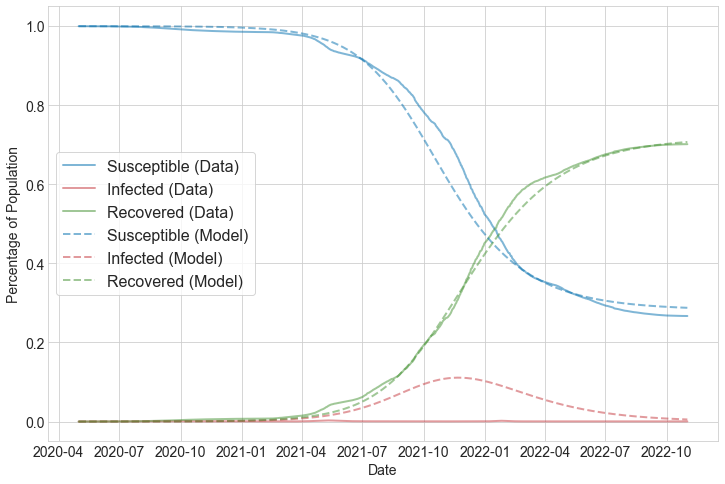

cost: 85051490.53250012


In [13]:
initial_guesses = [initial_guess_for_beta, initial_guess_for_gamma]
result = minimize(
    objective_function,
    initial_guesses,
    args=(y0, t, N),
    method='Nelder-Mead',
)
optimal_beta, optimal_gamma = result.x
print(f"optimal_beta: {optimal_beta} optimal_gamma: {optimal_gamma}")
print(f"optimal_beta/optimal_gamma: {optimal_beta/optimal_gamma}")

ret = odeint(deriv, y0, t, args=(N, optimal_beta, optimal_gamma))
S, I, R = ret.T

plt.figure(figsize=(12, 8))
plt.plot(df['date'], df['S']/N, color="#006EAE", alpha=0.5, lw=2, label='Susceptible (Data)')
plt.plot(df['date'], df['I']/N, color="#C5373D", alpha=0.5, lw=2, label='Infected (Data)')
plt.plot(df['date'], df['R']/N, color="#429130", alpha=0.5, lw=2, label='Recovered (Data)')

plt.plot(df['date'], S/N, color="#006EAE", linestyle="--", alpha=0.5, lw=2, label='Susceptible (Model)')
plt.plot(df['date'], I/N, color="#C5373D", linestyle="--", alpha=0.5, lw=2, label='Infected (Model)')
plt.plot(df['date'], R/N, color="#429130", linestyle="--", alpha=0.5, lw=2, label='Recovered (Model)')

plt.xlabel('Date')
plt.ylabel('Percentage of Population')
plt.tick_params(length=0)
plt.grid(True)
# legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# legend.get_frame().set_alpha(0.5)
plt.legend()
plt.savefig(os.path.join(OUTPUT_DIR, "SIR_model_" + LOCATION_CHOOSEN + ".eps"), bbox_inches="tight")
plt.show()

SIR_cost = compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R)
print(f"cost: {SIR_cost}")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


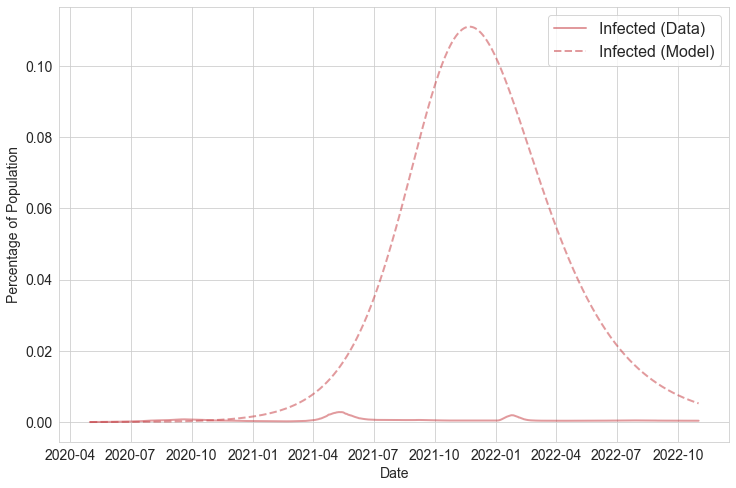

In [14]:
plt.figure(figsize=(12, 8))
plt.plot(df['date'], df['I']/N, color="#C5373D", alpha=0.5, lw=2, label='Infected (Data)')
plt.plot(df['date'], I/N, color="#C5373D", linestyle="--", alpha=0.5, lw=2, label='Infected (Model)')
plt.xlabel('Date')
plt.ylabel('Percentage of Population')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, "SIR_model_infections_" + LOCATION_CHOOSEN + ".eps"), bbox_inches="tight")
plt.show()

In [15]:
r0 = optimal_beta/optimal_gamma

df["S_modelled"] = S
df["I_modelled"] = I
df["R_modelled"] = R
df["r_eff_modelled"] = r0 * df["S_modelled"]/N
df["r_eff_actual"] = r0 * df["S"]/df["N"]

## SIR Model with Lockdown

In [16]:
def deriv(y, t, N, beta, gamma, lockdown):
    S, I, R = y
    t = min(int(t), len(lockdown) - 1)  # Ensure t is an integer and within the range of 'lockdown'
    dSdt = -beta * (1 - lockdown[int(t)]) * S * I / N
    dIdt = beta * (1 - lockdown[int(t)]) * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def integrate_system(params, y0, t, N, lockdown):
    beta, gamma = params
    result = odeint(deriv, y0, t, args=(N, beta, gamma, lockdown))
    return result

def objective_function(params, y0, t, N, lockdown):
    predictions = integrate_system(params, y0, t, N, lockdown)
    S, I, R = predictions.T
    cost = (compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R))
    return cost

In [17]:
N = df.loc[min(df.index), ['N']].item()
y0 = df.loc[min(df.index), ['S']].item(), df.loc[min(df.index), ['I']].item(), df.loc[min(df.index), ['R']].item()
initial_guess_for_beta, initial_guess_for_gamma = 0.2, 1./10 
days_difference = (max(df['date']) - min(df['date'])).days
t = np.linspace(0, days_difference, days_difference + 1)

optimal_beta: 0.4013340889432941 optimal_gamma: 0.09017476605499258
optimal_beta/optimal_gamma: 4.450625230328213


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


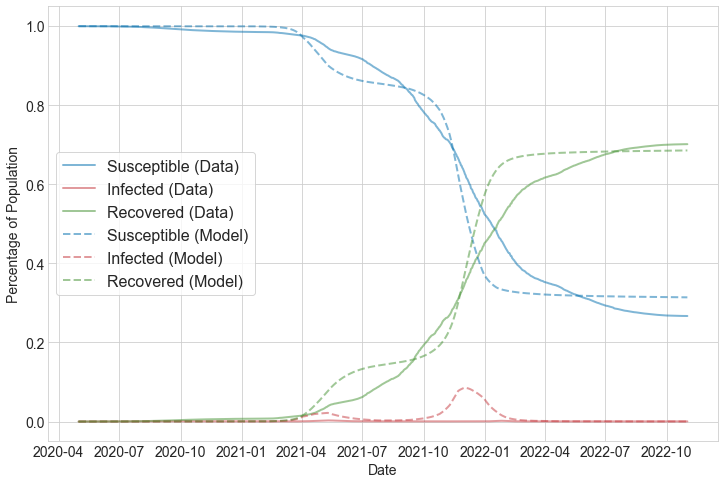

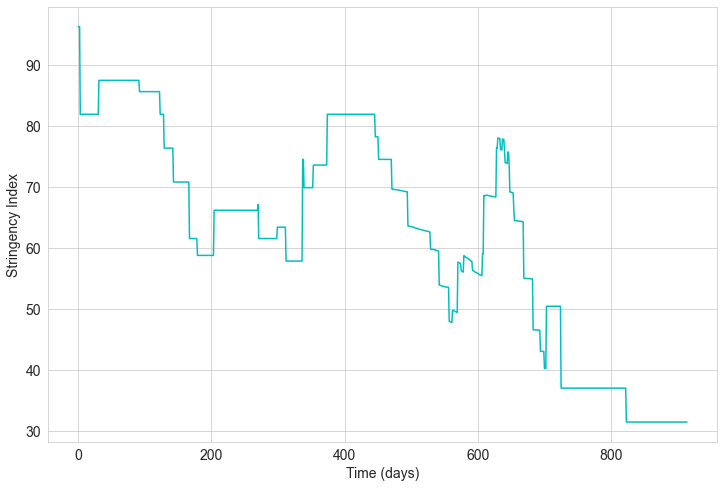

cost: 98438821.45587364


In [18]:
initial_guesses = [initial_guess_for_beta, initial_guess_for_gamma]
lockdown = list(df['stringency_index'].values / 100)
result = minimize(
    objective_function,
    initial_guesses,
    args=(y0, t, N, lockdown),
    method='Nelder-Mead',
)
optimal_beta, optimal_gamma = result.x
print(f"optimal_beta: {optimal_beta} optimal_gamma: {optimal_gamma}")
print(f"optimal_beta/optimal_gamma: {optimal_beta/optimal_gamma}")

ret = odeint(deriv, y0, t, args=(N, optimal_beta, optimal_gamma, lockdown))
S, I, R = ret.T

plt.figure(figsize=(12, 8))
plt.plot(df['date'], df['S']/N, color="#006EAE", alpha=0.5, lw=2, label='Susceptible (Data)')
plt.plot(df['date'], df['I']/N, color="#C5373D", alpha=0.5, lw=2, label='Infected (Data)')
plt.plot(df['date'], df['R']/N, color="#429130", alpha=0.5, lw=2, label='Recovered (Data)')

plt.plot(df['date'], S/N, color="#006EAE", linestyle="--", alpha=0.5, lw=2, label='Susceptible (Model)')
plt.plot(df['date'], I/N, color="#C5373D", linestyle="--", alpha=0.5, lw=2, label='Infected (Model)')
plt.plot(df['date'], R/N, color="#429130", linestyle="--", alpha=0.5, lw=2, label='Recovered (Model)')

plt.xlabel('Date')
plt.ylabel('Percentage of Population')
plt.tick_params(length=0)
plt.grid(True)
# legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# legend.get_frame().set_alpha(0.5)
plt.legend()
plt.savefig(os.path.join(OUTPUT_DIR, "SIR_model_with_lockdown_" + LOCATION_CHOOSEN + ".eps"), bbox_inches="tight")
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(t, df['stringency_index'], 'c')
plt.xlabel('Time (days)')
plt.ylabel('Stringency Index')
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, "stringency_varying_with_time_" + LOCATION_CHOOSEN + ".eps"), bbox_inches="tight")
plt.show()

SIR_with_lockdown_cost = compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R)
print(f"cost: {SIR_with_lockdown_cost}")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


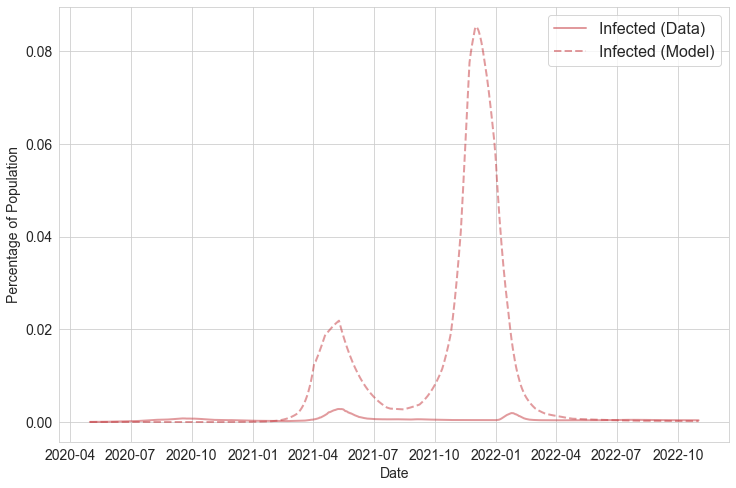

In [19]:
plt.figure(figsize=(12, 8))
plt.plot(df['date'], df['I']/N, color="#C5373D", alpha=0.5, lw=2, label='Infected (Data)')
plt.plot(df['date'], I/N, color="#C5373D", linestyle="--", alpha=0.5, lw=2, label='Infected (Model)')
plt.xlabel('Date')
plt.ylabel('Percentage of Population')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, "SIR_model_with_lockdown_infections_" + LOCATION_CHOOSEN + ".eps"), bbox_inches="tight")
plt.show()

In [20]:
r0 = optimal_beta/optimal_gamma

df["S_modelled_with_lockdown"] = S
df["I_modelled_with_lockdown"] = I
df["R_modelled_with_lockdown"] = R
df["r_eff_modelled_with_lockdown"] = r0 * df["S_modelled_with_lockdown"]/N
df["r_eff_actual_with_lockdown"] = r0 * df["S"]/df["N"]

## SIRV Model Lockdown

In [21]:
def deriv(y, t, N, beta, gamma, nu, lockdown):
    S, I, R = y
    t = min(int(t), len(lockdown) - 1)  # Ensure t is an integer and within the range of 'lockdown'
    dSdt = -beta * (1 - lockdown[int(t)]) * S * I / N - nu * S
    dIdt = beta * (1 - lockdown[int(t)]) * S * I / N - gamma * I
    dRdt = gamma * I + nu * S
    return dSdt, dIdt, dRdt

def integrate_system(params, y0, t, N, lockdown):
    beta, gamma, nu = params
    result = odeint(deriv, y0, t, args=(N, beta, gamma, nu, lockdown))
    return result

def objective_function(params, y0, t, N, lockdown):
    predictions = integrate_system(params, y0, t, N, lockdown)
    S, I, R = predictions.T
    cost = (compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R))
    return cost

In [22]:
N = df.loc[min(df.index), ['N']].item()
y0 = df.loc[min(df.index), ['S']].item(), df.loc[min(df.index), ['I']].item(), df.loc[min(df.index), ['R']].item()
# initial_guess_for_beta, initial_guess_for_gamma, initial_guess_for_nu = 0.2, 1./10, 0.0001
# initial_guess_for_beta, initial_guess_for_gamma, initial_guess_for_nu = 0.2, 1./10, 0.000001
initial_guess_for_beta, initial_guess_for_gamma, initial_guess_for_nu = 0.2, 1./10, 0.000001
days_difference = (max(df['date']) - min(df['date'])).days
t = np.linspace(0, days_difference, days_difference + 1)

optimal_beta: 0.40897034072952304 optimal_gamma: 0.09196829370123338 optimal_nu: 2.9044029843851936e-05
optimal_beta/optimal_gamma: 4.446862329077204


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


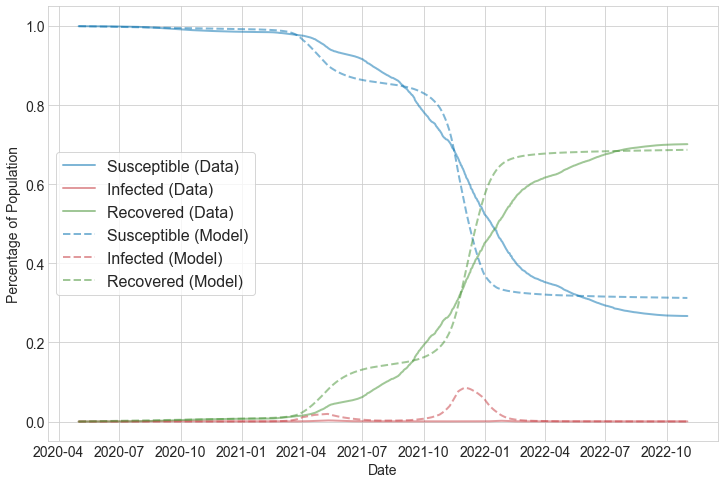

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


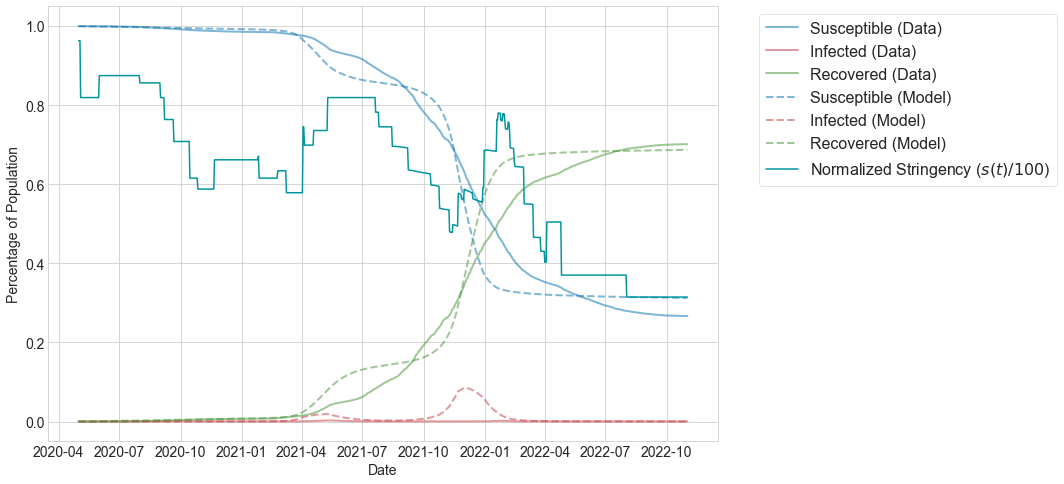

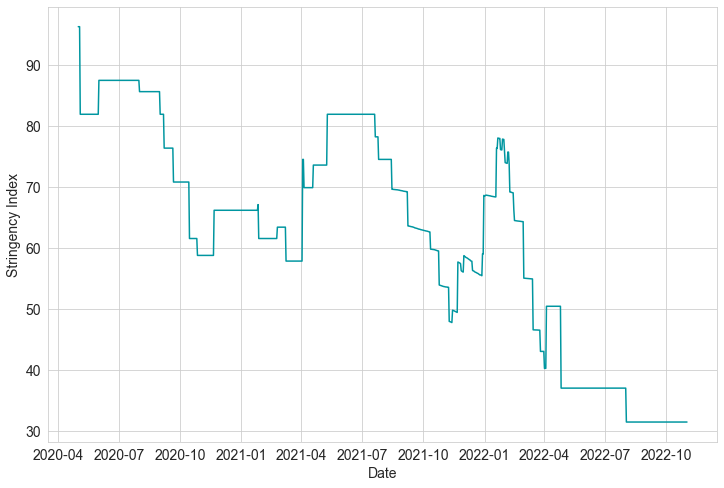

cost: 94636860.38436058


In [23]:
initial_guesses = [initial_guess_for_beta, initial_guess_for_gamma, initial_guess_for_nu]
lockdown = list(df['stringency_index'].values / 100)
result = minimize(
    objective_function,
    initial_guesses,
    args=(y0, t, N, lockdown),
    method='Nelder-Mead',
)
optimal_beta, optimal_gamma, optimal_nu = result.x
print(f"optimal_beta: {optimal_beta} optimal_gamma: {optimal_gamma} optimal_nu: {optimal_nu}")
print(f"optimal_beta/optimal_gamma: {optimal_beta/optimal_gamma}")

ret = odeint(deriv, y0, t, args=(N, optimal_beta, optimal_gamma, optimal_nu, lockdown))
S, I, R = ret.T

plt.figure(figsize=(12, 8))
plt.plot(df['date'], df['S']/N, color="#006EAE", alpha=0.5, lw=2, label='Susceptible (Data)')
plt.plot(df['date'], df['I']/N, color="#C5373D", alpha=0.5, lw=2, label='Infected (Data)')
plt.plot(df['date'], df['R']/N, color="#429130", alpha=0.5, lw=2, label='Recovered (Data)')

plt.plot(df['date'], S/N, color="#006EAE", linestyle="--", alpha=0.5, lw=2, label='Susceptible (Model)')
plt.plot(df['date'], I/N, color="#C5373D", linestyle="--", alpha=0.5, lw=2, label='Infected (Model)')
plt.plot(df['date'], R/N, color="#429130", linestyle="--", alpha=0.5, lw=2, label='Recovered (Model)')

plt.xlabel('Date')
plt.ylabel('Percentage of Population')
plt.tick_params(length=0)
plt.grid(True)
# legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# legend.get_frame().set_alpha(0.5)
plt.legend()
plt.savefig(os.path.join(OUTPUT_DIR, "SIRV_model_with_lockdown_" + LOCATION_CHOOSEN + ".eps"), bbox_inches="tight")
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(df['date'], df['S']/N, color="#006EAE", alpha=0.5, lw=2, label='Susceptible (Data)')
plt.plot(df['date'], df['I']/N, color="#C5373D", alpha=0.5, lw=2, label='Infected (Data)')
plt.plot(df['date'], df['R']/N, color="#429130", alpha=0.5, lw=2, label='Recovered (Data)')

plt.plot(df['date'], S/N, color="#006EAE", linestyle="--", alpha=0.5, lw=2, label='Susceptible (Model)')
plt.plot(df['date'], I/N, color="#C5373D", linestyle="--", alpha=0.5, lw=2, label='Infected (Model)')
plt.plot(df['date'], R/N, color="#429130", linestyle="--", alpha=0.5, lw=2, label='Recovered (Model)')

plt.plot(df['date'], df['stringency_index']/100, color='#0096A0', label=r"Normalized Stringency ($s(t)/100$)")

plt.xlabel('Date')
plt.ylabel('Percentage of Population')
plt.tick_params(length=0)
plt.grid(True)
legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
legend.get_frame().set_alpha(0.5)
plt.savefig(os.path.join(OUTPUT_DIR, "SIRV_model_with_lockdown_with_stringency_" + LOCATION_CHOOSEN + ".eps"), bbox_inches="tight")
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(df['date'], df['stringency_index'], color='#0096A0')
plt.xlabel('Date')
plt.ylabel('Stringency Index')
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, "stringency_varying_with_time_" + LOCATION_CHOOSEN + ".eps"), bbox_inches="tight")
plt.show()

SIRV_with_lockdown_cost = compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R)
print(f"cost: {SIRV_with_lockdown_cost}")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


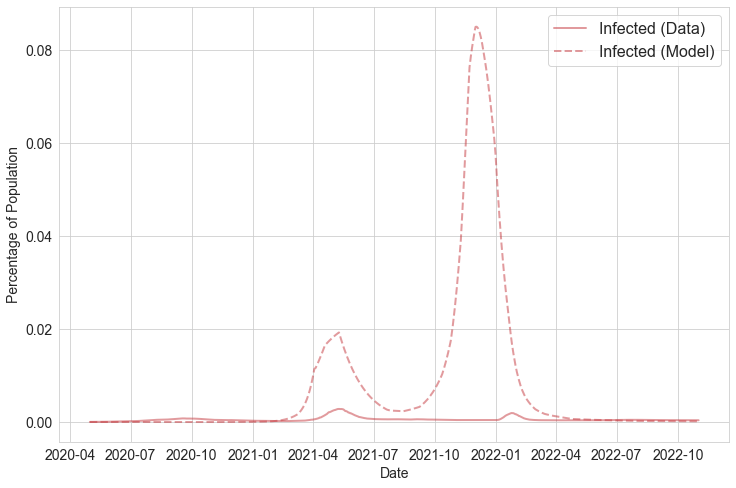

In [24]:
plt.figure(figsize=(12, 8))
plt.plot(df['date'], df['I']/N, color="#C5373D", alpha=0.5, lw=2, label='Infected (Data)')
plt.plot(df['date'], I/N, color="#C5373D", linestyle="--", alpha=0.5, lw=2, label='Infected (Model)')
plt.xlabel('Date')
plt.ylabel('Percentage of Population')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, "SIRV_model_with_lockdown_infections_" + LOCATION_CHOOSEN + ".eps"), bbox_inches="tight")
plt.show()

In [25]:
r0 = optimal_beta/optimal_gamma

df["S_modelled_with_lockdown_with_vaccination"] = S
df["I_modelled_with_lockdown_with_vaccination"] = I
df["R_modelled_with_lockdown_with_vaccination"] = R
df["r_eff_modelled_with_lockdown_with_vaccination"] = r0 * df["S_modelled_with_lockdown_with_vaccination"]/N
df["r_eff_actual_with_lockdown_with_vaccination"] = r0 * df["S"]/df["N"]

## Vaccination dependent on Time

In [26]:
window_length = 20

def deriv(y, t, N, nu, lockdown):
    S, I, R = y
    t = min(int(t), len(lockdown) - 1)  # Ensure t is an integer and within the range of 'lockdown'
    dSdt = -optimal_beta * (1 - lockdown[int(t)]) * S * I / N - nu * S
    dIdt = optimal_beta * (1 - lockdown[int(t)]) * S * I / N - optimal_gamma * I
    dRdt = optimal_gamma * I + nu * S
#     print(dSdt, dIdt, dRdt)
    return dSdt[0], dIdt, dRdt[0]

def integrate_system(params, y0, t, N, lockdown):
    nu = params
    result = odeint(deriv, y0, t, args=(N, nu, lockdown), hmax=1.0)
    return result

def objective_function(params, y0, t, N, lockdown, days_window):
    predictions = integrate_system(params, y0, t, N, lockdown)
    S, I, R = predictions.T
    cost = (compute_cost(df['S'][days_window-window_length:days_window], S) + 
            compute_cost(df['I'][days_window-window_length:days_window], I) + 
            compute_cost(df['R'][days_window-window_length:days_window], R))
    return cost

In [27]:
N = df.loc[min(df.index), ['N']].item()
y0 = df.loc[min(df.index), ['S']].item(), df.loc[min(df.index), ['I']].item(), df.loc[min(df.index), ['R']].item()
initial_guess_for_beta, initial_guess_for_gamma, initial_guess_for_nu = 0.2, 1./10, 0.001

In [28]:
nu_changing_with_time = []
time_points_for_nu = []
for days_window in range(window_length, days_difference, window_length):
    lockdown = list(df['stringency_index'].values / 100)[days_window - 10:days_window]
    t = np.linspace(days_window - window_length, days_window, window_length)
    initial_guesses = [initial_guess_for_nu]
    result = minimize(
        objective_function,
        initial_guesses,
        args=(y0, t, N, lockdown, days_window),
        method='Nelder-Mead',
    )
    optimal_nu = result.x
    print(f"optimal_nu: {optimal_nu}")
    if optimal_nu < 0.0:
        optimal_nu = [0.0]
    nu_changing_with_time.append(optimal_nu[0])
    time_points_for_nu.append(days_window - window_length)
    y0 = df.loc[days_window, ['S']].item(), df.loc[days_window, ['I']].item(), df.loc[days_window, ['R']].item()

optimal_nu: [-2.41088867e-07]
optimal_nu: [-2.43484974e-07]
optimal_nu: [4.07218933e-07]
optimal_nu: [1.84783936e-06]
optimal_nu: [7.99455643e-06]
optimal_nu: [7.00564384e-06]
optimal_nu: [-3.88770103e-06]
optimal_nu: [-9.42312479e-06]
optimal_nu: [-8.6126411e-05]
optimal_nu: [-6.2001133e-05]
optimal_nu: [-2.50025302e-05]
optimal_nu: [-2.87252188e-05]
optimal_nu: [-2.68959641e-05]
optimal_nu: [-3.43594193e-05]
optimal_nu: [2.45387256e-06]
optimal_nu: [0.00010706]
optimal_nu: [0.00015083]
optimal_nu: [0.00036796]
optimal_nu: [0.00074174]
optimal_nu: [0.000325]
optimal_nu: [0.00027749]
optimal_nu: [0.00092022]
optimal_nu: [0.00109287]
optimal_nu: [0.00086984]
optimal_nu: [0.00181926]
optimal_nu: [0.00276877]
optimal_nu: [0.00225196]
optimal_nu: [0.0026587]
optimal_nu: [0.00460345]
optimal_nu: [0.00568603]
optimal_nu: [0.00525362]
optimal_nu: [0.00516585]
optimal_nu: [0.00535744]
optimal_nu: [0.00344614]
optimal_nu: [0.00190317]
optimal_nu: [0.0012968]
optimal_nu: [0.002365]
optimal_nu: [

## SIRV model with time varying nu

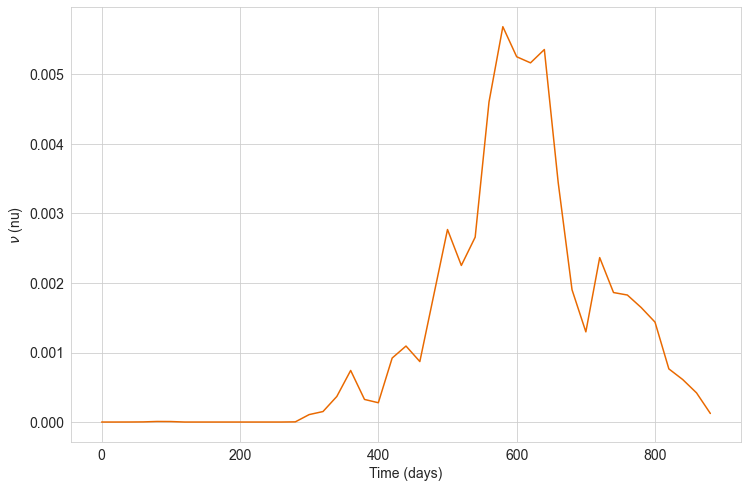

In [29]:
plt.figure(figsize=(12, 8))
plt.plot(time_points_for_nu, nu_changing_with_time, color="#E96900")
plt.xlabel('Time (days)')
plt.ylabel(r'$\nu$ (nu)')
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, "nu_varying_with_time_" + LOCATION_CHOOSEN + ".eps"), bbox_inches="tight")
plt.show()

In [30]:
new_time_points = np.arange(0, 915, 1)  # Adjust the range and step size as needed

# Interpolate nu_changing_with_time to match the new time points
interpolated_nu = np.interp(new_time_points, time_points_for_nu, nu_changing_with_time)

# Print the interpolated nu array and its length
print(len(interpolated_nu))

915


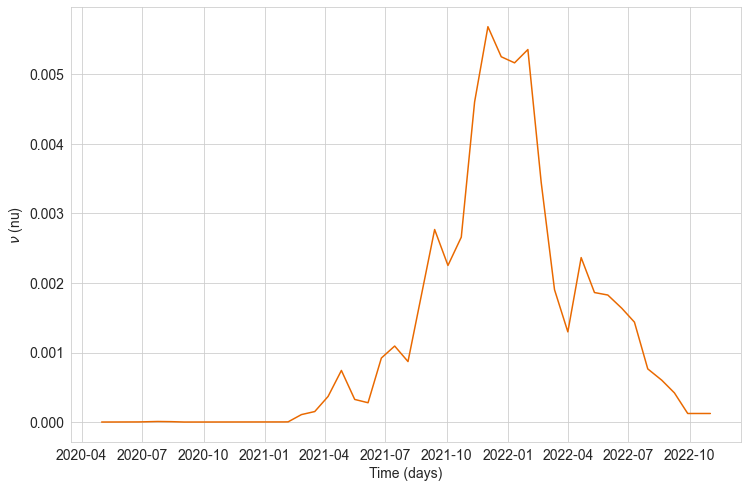

In [31]:
plt.figure(figsize=(12, 8))
plt.plot(df['date'], interpolated_nu, color="#E96900")
plt.xlabel('Time (days)')
plt.ylabel(r'$\nu$ (nu)')
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, "interpolated_nu_varying_with_time_" + LOCATION_CHOOSEN + ".eps"), bbox_inches="tight")
plt.show()

In [32]:
df['nu_varying_with_time'] = interpolated_nu

In [33]:
def deriv(y, t, N, beta, gamma, nu_varying, lockdown):
    S, I, R = y
    t = min(int(t), len(lockdown) - 1)  # Ensure t is an integer and within the range of 'lockdown'
    dSdt = -beta * (1 - lockdown[int(t)]) * S * I / N - nu_varying[int(t)] * S
    dIdt = beta * (1 - lockdown[int(t)]) * S * I / N - gamma * I
    dRdt = gamma * I + nu_varying[int(t)] * S
    return dSdt, dIdt, dRdt

def integrate_system(params, y0, t, N, nu_varying, lockdown):
    beta, gamma = params
    result = odeint(deriv, y0, t, args=(N, beta, gamma, nu_varying, lockdown))
    return result

def objective_function(params, y0, t, N, nu_varying, lockdown):
    predictions = integrate_system(params, y0, t, N, nu_varying, lockdown)
    S, I, R = predictions.T
    cost = (compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R))
    return cost

In [34]:
N = df.loc[min(df.index), ['N']].item()
y0 = df.loc[min(df.index), ['S']].item(), df.loc[min(df.index), ['I']].item(), df.loc[min(df.index), ['R']].item()
initial_guess_for_beta, initial_guess_for_gamma = 0.2, 1./10
days_difference = (max(df['date']) - min(df['date'])).days
t = np.linspace(0, days_difference, days_difference + 1)

optimal_beta: 0.5129414911377119 optimal_gamma: 0.12716245167626106
optimal_beta/optimal_gamma: 4.033749620081199


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


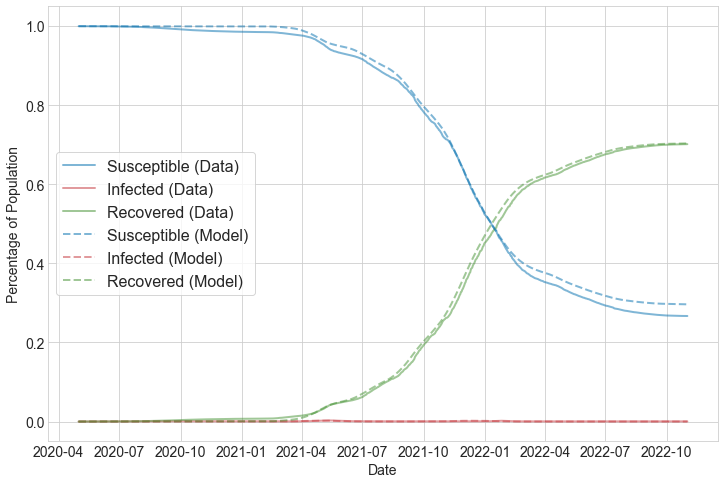

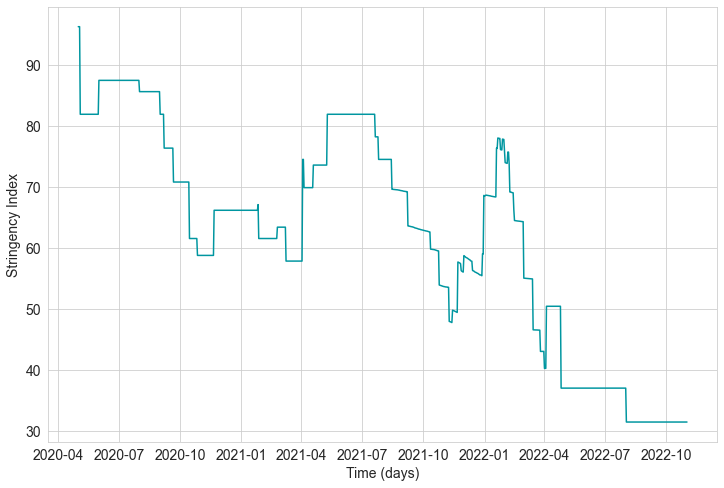

cost: 29742589.698910963


In [35]:
initial_guesses = [initial_guess_for_beta, initial_guess_for_gamma]
lockdown = list(df['stringency_index'].values / 100)
nu_varying = list(df['nu_varying_with_time'].values)
result = minimize(
    objective_function,
    initial_guesses,
    args=(y0, t, N, nu_varying, lockdown),
    method='Nelder-Mead',
)
optimal_beta, optimal_gamma = result.x
print(f"optimal_beta: {optimal_beta} optimal_gamma: {optimal_gamma}")
print(f"optimal_beta/optimal_gamma: {optimal_beta/optimal_gamma}")

ret = odeint(deriv, y0, t, args=(N, optimal_beta, optimal_gamma, nu_varying, lockdown))
S, I, R = ret.T

plt.figure(figsize=(12, 8))
plt.plot(df['date'], df['S']/N, color="#006EAE", alpha=0.5, lw=2, label='Susceptible (Data)')
plt.plot(df['date'], df['I']/N, color="#C5373D", alpha=0.5, lw=2, label='Infected (Data)')
plt.plot(df['date'], df['R']/N, color="#429130", alpha=0.5, lw=2, label='Recovered (Data)')

plt.plot(df['date'], S/N, color="#006EAE", linestyle="--", alpha=0.5, lw=2, label='Susceptible (Model)')
plt.plot(df['date'], I/N, color="#C5373D", linestyle="--", alpha=0.5, lw=2, label='Infected (Model)')
plt.plot(df['date'], R/N, color="#429130", linestyle="--", alpha=0.5, lw=2, label='Recovered (Model)')

plt.xlabel('Date')
plt.ylabel('Percentage of Population')
plt.tick_params(length=0)
plt.grid(True)
# legend = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# legend.get_frame().set_alpha(0.5)
plt.legend()
plt.savefig(os.path.join(OUTPUT_DIR, "SIRV_model_with_lockdown_time_varying_nu_" + LOCATION_CHOOSEN + ".eps"), bbox_inches="tight")
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(df['date'], df['stringency_index'], color='#0096A0')
plt.xlabel('Time (days)')
plt.ylabel('Stringency Index')
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, "stringency_varying_with_time_" + LOCATION_CHOOSEN + ".eps"), bbox_inches="tight")
plt.show()

SIRV_with_lockdown_time_varying_nu_cost = compute_cost(df['S'], S) + compute_cost(df['I'], I) + compute_cost(df['R'], R)
print(f"cost: {SIRV_with_lockdown_time_varying_nu_cost}")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


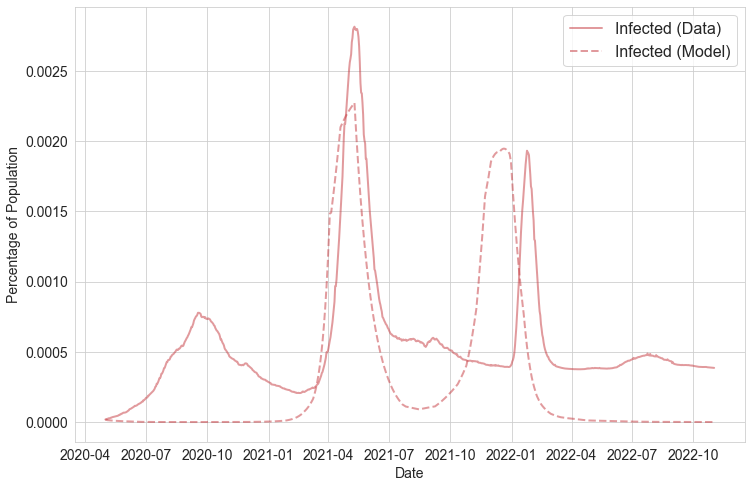

In [36]:
plt.figure(figsize=(12, 8))
plt.plot(df['date'], df['I']/N, color="#C5373D", alpha=0.5, lw=2, label='Infected (Data)')
plt.plot(df['date'], I/N, color="#C5373D", linestyle="--", alpha=0.5, lw=2, label='Infected (Model)')
plt.xlabel('Date')
plt.ylabel('Percentage of Population')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, "SIRV_model_with_lockdown_infections_time_varying_nu_" + LOCATION_CHOOSEN + ".eps"), bbox_inches="tight")
plt.show()

In [37]:
r0 = optimal_beta/optimal_gamma

df["S_modelled_with_lockdown_with_vaccination_time_varying_nu"] = S
df["I_modelled_with_lockdown_with_vaccination_time_varying_nu"] = I
df["R_modelled_with_lockdown_with_vaccination_time_varying_nu"] = R
df["r_eff_modelled_with_lockdown_with_vaccination_time_varying_nu"] = r0 * df["S_modelled_with_lockdown_with_vaccination_time_varying_nu"]/N
df["r_eff_actual_with_lockdown_with_vaccination_time_varying_nu"] = r0 * df["S"]/df["N"]

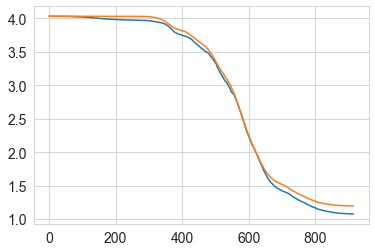

In [38]:
plt.plot(df["r_eff_actual_with_lockdown_with_vaccination_time_varying_nu"])
plt.plot(df["r_eff_modelled_with_lockdown_with_vaccination_time_varying_nu"])

In [39]:
print(max(df["I_modelled_with_lockdown_with_vaccination_time_varying_nu"]/N))

0.0022733374452361317


In [40]:
optimal_values = {
    'optimal_beta': optimal_beta,
    'optimal_gamma': optimal_gamma,
}

with open(OPTIMAL_VALUES_FILE, "w") as outfile: 
    json.dump(optimal_values, outfile)

In [41]:
#breakcode

## Comparing costs

In [42]:
print(SIR_cost, SIR_with_lockdown_cost, SIRV_with_lockdown_cost, SIRV_with_lockdown_time_varying_nu_cost)

85051490.53250012 98438821.45587364 94636860.38436058 29742589.698910963


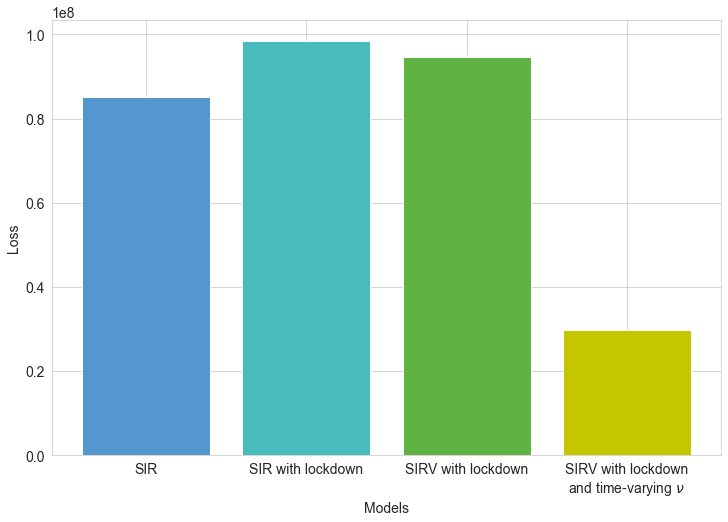

In [43]:
models = ['SIR', 'SIR with lockdown', 'SIRV with lockdown', r"""SIRV with lockdown
and time-varying $\nu$"""]

# Corresponding costs
costs = [SIR_cost, SIR_with_lockdown_cost, SIRV_with_lockdown_cost, SIRV_with_lockdown_time_varying_nu_cost]

plt.figure(figsize=(12, 8))
plt.bar(models, costs, color =["#5496CE", "#48BCBC", "#5EB342", "#C5C500"])
plt.xlabel('Models')
plt.ylabel('Loss')
# plt.title('Costs of Different Models')
plt.grid(True)
plt.savefig(os.path.join(OUTPUT_DIR, "comparing_costs_" + LOCATION_CHOOSEN + ".eps"), bbox_inches="tight")
plt.show()
plt.show()

In [44]:
stringency_data_points = np.arange(0, 100, 0.5)
fit_line_loaded = np.poly1d(np.load(STRINGENCY_BASED_GDP))
predicted_gdp = fit_line_loaded(stringency_data_points)
MIN_GDP = min(predicted_gdp)
MAX_GDP = max(predicted_gdp)

In [45]:
df['gdp_min_max_normalized'] = (df['gdp_normalized'] - MIN_GDP) / (MAX_GDP - MIN_GDP)
df['gdp_normalized_modelled_min_max_normalized'] =  (df['gdp_normalized_modelled'] - MIN_GDP) / (MAX_GDP - MIN_GDP)

In [46]:
df.to_csv(os.path.join(DATA_CACHE_DIR, LOCATION_CHOOSEN + "_merged_data.csv"))

## BREAKPOINT

In [2]:
df = pd.read_csv(os.path.join(DATA_CACHE_DIR, LOCATION_CHOOSEN + "_merged_data.csv"))
df['date'] = pd.to_datetime(df['date'])

with open(OPTIMAL_VALUES_FILE, 'r') as f:
    optimal_values_read = f.read()
    optimal_values = json.loads(optimal_values_read)
optimal_beta = optimal_values['optimal_beta']
optimal_gamma = optimal_values['optimal_gamma']

r0 = optimal_beta/optimal_gamma

stringency_data_points = np.arange(0, 100, 0.5)
fit_line_loaded = np.poly1d(np.load(STRINGENCY_BASED_GDP))
predicted_gdp = fit_line_loaded(stringency_data_points)
MIN_GDP = min(predicted_gdp)
MAX_GDP = max(predicted_gdp)

In [3]:
df.diff()['stringency_index'][1:].describe()

count    914.000000
mean      -0.070919
std        1.427145
min      -14.360000
25%        0.000000
50%        0.000000
75%        0.000000
max       16.670000
Name: stringency_index, dtype: float64

In [4]:
df['stringency_index'].describe()

count    915.000000
mean      61.965049
std       17.669831
min       31.480000
25%       50.460000
50%       63.510000
75%       76.245000
max       96.300000
Name: stringency_index, dtype: float64

In [5]:
df['nu_varying_with_time']

0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
910    0.000123
911    0.000123
912    0.000123
913    0.000123
914    0.000123
Name: nu_varying_with_time, Length: 915, dtype: float64

In [18]:
info_saved_df = pd.read_csv("output/info_save/-198030.09.csv")
stringency_index_from_actions_taken = info_saved_df['stringency_index']

In [19]:
print(len(stringency_index_from_actions_taken))
print(len(df['stringency_index']))

915
915


In [20]:
def calculate_reward_weighted(gdp_min_max_normalized_list, r_eff_list):
    GDP_WEIGHT_1 = 100 # change this value and see how it affects the reward
    GDP_WEIGHT_2 = 200 # change this value and see how it affects the reward
    reward = []
    for i in range(len(gdp_min_max_normalized_list)):
        if r_eff_list[i] > 1.9:
            reward.append(-20 * r_eff_list[i])
        elif r_eff_list[i] <= 1.9 and r_eff_list[i] >= 1.5:
            reward.append(GDP_WEIGHT_1 * gdp_min_max_normalized_list[i])
        else:
            reward.append(GDP_WEIGHT_2 * gdp_min_max_normalized_list[i])
    return reward

In [21]:
def deriv(y, t, N, beta, gamma, nu_varying, lockdown):
    S, I, R = y
    t = min(int(t), len(lockdown) - 1)  # Ensure t is an integer and within the range of 'lockdown'
    dSdt = -beta * (1 - lockdown[int(t)]) * S * I / N - nu_varying[int(t)] * S
    dIdt = beta * (1 - lockdown[int(t)]) * S * I / N - gamma * I
    dRdt = gamma * I + nu_varying[int(t)] * S
    return dSdt, dIdt, dRdt

def reward_strategy(stringency_moves, reward_strategy_choosen, sir_technique):   
    N = df.loc[min(df.index), ["N"]].item()
    y0 = df.loc[min(df.index), ["S"]].item(), df.loc[min(df.index), ["I"]].item(), df.loc[min(df.index), ["R"]].item()
    days_difference = (max(df["date"]) - min(df["date"])).days
    t = np.linspace(0, days_difference, days_difference + 1)
    nu_varying = list(df['nu_varying_with_time'])
    
    store_S = np.zeros(days_difference + 1)
    store_I = np.zeros(days_difference + 1)
    store_R = np.zeros(days_difference + 1)

    # sir_technique 1 is faster
    # 2 is just to check whether the results match with 1
    moves_lockdown = stringency_index_from_actions_taken / 100
    if sir_technique == 1:
        moves_ret = odeint(deriv, y0, t, args=(N, optimal_beta, optimal_gamma, nu_varying, moves_lockdown))
        moves_S, moves_I, moves_R = moves_ret.T

        df["S_moves"] = moves_S
        df["I_moves"] = moves_I
        df["R_moves"] = moves_R
    elif sir_technique == 2:
        for ith_day in range(days_difference + 1):
            stringency_index_random_choice.append(stringency_index_from_actions_taken[ith_day])
            t = np.linspace(0, ith_day, ith_day + 1)
            moves_ret = odeint(deriv, y0, t, args=(N, optimal_beta, optimal_gamma, nu_varying, np.array(stringency_index_random_choice) / 100))
            moves_S, moves_I, moves_R = moves_ret.T
            store_S[ith_day] = moves_S[-1]
            store_I[ith_day] = moves_I[-1]
            store_R[ith_day] = moves_R[-1]
        df["S_moves"] = store_S
        df["I_moves"] = store_I
        df["R_moves"] = store_R
    
    modelling_type = "with_lockdown_with_vaccination_time_varying_nu"
    df["r_eff_moves_" + modelling_type] = r0 * df["S_moves"] / N
    df["gdp_normalized_moves_min_max_normalized"] = ((fit_line_loaded(stringency_index_from_actions_taken) - MIN_GDP) / (MAX_GDP - MIN_GDP))
    
    modelled_ret = odeint(deriv, y0, t, args=(N, optimal_beta, optimal_gamma, nu_varying, (df["stringency_index"]) / 100))
    modelled_S, modelled_I, modelled_R = modelled_ret.T
    
    df["S_modelled_" + modelling_type + "_inside_plot"] = modelled_S
    df["I_modelled_" + modelling_type + "_inside_plot"] = modelled_I
    df["R_modelled_" + modelling_type + "_inside_plot"] = modelled_R
    
    plt.figure(figsize=(10, 6))
    plt.plot(df["S_modelled_" + modelling_type + "_inside_plot"], color="b", label="S_modelled")
    plt.plot(df["I_modelled_" + modelling_type + "_inside_plot"], color="r", label="I_modelled")
    plt.plot(df["R_modelled_" + modelling_type + "_inside_plot"], color="g", label="R_modelled")
    plt.plot(df["S_moves"], "b--", label="S_moves")
    plt.plot(df["I_moves"], "r--", label="I_moves")
    plt.plot(df["R_moves"], "g--", label="R_moves")
    plt.xlabel("days")
    plt.ylabel("Population")
    plt.title("SIR_dynamics")
    plt.legend()
    plt.show()
    
    
    plt.figure(figsize=(10, 6))
    plt.plot(df["stringency_index"], color="b", label="actual")
    plt.plot(stringency_index_from_actions_taken , color="g", label="moves")
    plt.xlabel("days")
    plt.ylabel("stringency")
    plt.title("stringency")
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(df["r_eff_actual_" + modelling_type], color="b", label="actual")
    plt.plot(df["r_eff_modelled_" + modelling_type], color="r", label="modelled")
    plt.plot(df["r_eff_moves_" + modelling_type], color="g", label="moves")
    plt.xlabel("days")
    plt.ylabel("r_eff")
    plt.title("R_eff")
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(df["gdp_min_max_normalized"], color="b", label="actual")
    plt.plot(df["gdp_normalized_modelled_min_max_normalized"], color="r", label="modelled")
    plt.plot(df["gdp_normalized_moves_min_max_normalized"], color="g", label="moves")
    plt.xlabel("days")
    plt.ylabel("gdp")
    plt.title("GDP")
    plt.legend()
    plt.show()
        
    if reward_strategy_choosen == 1:
        plt.figure(figsize=(10, 6))
        plt.plot(df["gdp_min_max_normalized"] / df["r_eff_actual_" + modelling_type], color="b", label="reward(actual) = {reward}".format(reward = np.sum(df["gdp_min_max_normalized"] / df["r_eff_actual_" + modelling_type])))
        plt.plot(df["gdp_normalized_modelled_min_max_normalized"] / df["r_eff_modelled_" + modelling_type], color="r", label="reward(modelled) = {reward}".format(reward = np.sum(df["gdp_normalized_modelled_min_max_normalized"] / df["r_eff_modelled_" + modelling_type])))
        plt.plot(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_" + modelling_type], color="g", label="reward(modelled) = {reward}".format(reward = np.sum(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_" + modelling_type])))
        plt.xlabel("days")
        plt.ylabel("reward")
        plt.title("reward")
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(10, 6))
        plt.plot(df["gdp_min_max_normalized"] / df["r_eff_actual_" + modelling_type], color="b", label="reward(actual) = {reward}".format(reward = np.sum(df["gdp_min_max_normalized"] / df["r_eff_actual_" + modelling_type])))
        plt.plot(df["gdp_normalized_modelled_min_max_normalized"] / df["r_eff_modelled_" + modelling_type], color="r", label="reward(modelled) = {reward}".format(reward = np.sum(df["gdp_normalized_modelled_min_max_normalized"] / df["r_eff_modelled_" + modelling_type])))
        # plt.plot(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown"], color="g", label="reward(modelled) = {reward}".format(reward = np.sum(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown"])))
        plt.xlabel("days")
        plt.ylabel("reward")
        plt.title("reward")
        plt.legend()
        plt.show()
        
    if reward_strategy_choosen == 2:
        plt.figure(figsize=(10, 6))
        
        index_to_the_power_of = 0.0025
        plt.plot(df["gdp_min_max_normalized"] / df["r_eff_actual_" + modelling_type] * np.exp(df.index.to_numpy() * index_to_the_power_of), color="b", label="reward(actual) = {reward}".format(reward = np.sum(df["gdp_min_max_normalized"] / df["r_eff_actual_" + modelling_type] * np.exp(df.index.to_numpy() * index_to_the_power_of))))
        plt.plot(df["gdp_normalized_modelled_min_max_normalized"] / df["r_eff_modelled_" + modelling_type] * np.exp(df.index.to_numpy() * index_to_the_power_of), color="r", label="reward(modelled) = {reward}".format(reward = np.sum(df["gdp_normalized_modelled_min_max_normalized"] / df["r_eff_modelled_" + modelling_type] * np.exp(df.index.to_numpy() * index_to_the_power_of))))
        plt.plot(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_" + modelling_type] * np.exp(df.index.to_numpy() * index_to_the_power_of), color="g", label="reward(moves) = {reward}".format(reward = np.sum(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_" + modelling_type] * np.exp(df.index.to_numpy() * index_to_the_power_of))))
        plt.xlabel("days")
        plt.ylabel("reward")
        plt.title("reward")
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(10, 6))
        plt.plot(df["gdp_min_max_normalized"] / df["r_eff_actual_" + modelling_type] * np.exp(df.index.to_numpy() * index_to_the_power_of), color="b", label="reward(actual) = {reward}".format(reward = np.sum(df["gdp_min_max_normalized"] / df["r_eff_actual_" + modelling_type] * np.exp(df.index.to_numpy() * index_to_the_power_of))))
        plt.plot(df["gdp_normalized_modelled_min_max_normalized"] / df["r_eff_modelled_" + modelling_type] * np.exp(df.index.to_numpy() * index_to_the_power_of), color="r", label="reward(modelled) = {reward}".format(reward = np.sum(df["gdp_normalized_modelled_min_max_normalized"] / df["r_eff_modelled_" + modelling_type] * np.exp(df.index.to_numpy() * index_to_the_power_of))))
        # plt.plot(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of), color="g", label="reward(moves) = {reward}".format(reward = np.sum(df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of))))
        plt.xlabel("days")
        plt.ylabel("reward")
        plt.title("reward")
        plt.legend()
        plt.show()
        
    if reward_strategy_choosen == 3:
        
        # we need the epidemic to happen and also the I population to stay below a certain value (beds in the hospital) (10 multiple)
        # we need r_eff to be below 1 at an earlier stage (1 multiple)
        # we need to reward inertia by a small amount (0.1 multiple)
        
        hospital_capacity = 0.003
        hospital_capacity_punishment = -5000
        hospital_capacity_reward = 20
        # reward_I_percentage = -100 if self.I_proportion >= 0.082 else 0
        I_reward_actual = [hospital_capacity_punishment if I_percentage >= hospital_capacity else hospital_capacity_reward for I_percentage in df["I"] / df["N"]]
        I_reward_modelled = [hospital_capacity_punishment if I_percentage >= hospital_capacity else hospital_capacity_reward for I_percentage in df["I_modelled_" + modelling_type] / N]
        I_reward_moves = [hospital_capacity_punishment if I_percentage >= hospital_capacity else hospital_capacity_reward for I_percentage in df["I_moves"] / N]
        
        r_eff_reward_choosen = 10
        r_eff_punishment_choosen = -10
        r_eff_level = 1.9
        r_eff_reward_actual = [r_eff_reward_choosen if r_eff <= r_eff_level else r_eff_punishment_choosen for r_eff in df["r_eff_actual_" + modelling_type]]
        r_eff_reward_modelled = [r_eff_reward_choosen if r_eff <= r_eff_level else r_eff_punishment_choosen for r_eff in df["r_eff_modelled_" + modelling_type]]
        r_eff_reward_moves = [r_eff_reward_choosen if r_eff <= r_eff_level else r_eff_punishment_choosen for r_eff in df["r_eff_moves_" + modelling_type]]
        
        inertia_rewards_actual = [0] + [abs(diff)*5*-1 for diff in (df["stringency_index"][i] - df["stringency_index"][i - 1] for i in range(1, len(df)))]
        # modelled reward for intertia is same as actual
        inertia_rewards_modelled = [0] + [abs(diff)*5*-1 for diff in (df["stringency_index"][i] - df["stringency_index"][i - 1] for i in range(1, len(df)))]
        inertia_rewards_moves = [0] + [abs(diff)*5*-1 for diff in (stringency_index_from_actions_taken[i] - stringency_index_from_actions_taken[i - 1] for i in range(1, len(stringency_index_from_actions_taken)))]
        
        print("LENS: ", len(inertia_rewards_modelled), len(inertia_rewards_moves))
        # index_to_the_power_of = 0.00001
        # reward_actual = (df["gdp_min_max_normalized"] / df["r_eff_actual_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of)) + I_reward_actual + r_eff_reward_actual + inertia_rewards_actual
        # reward_modelled = (df["gdp_normalized_modelled_min_max_normalized"] / df["r_eff_modelled_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of)) + I_reward_modelled + r_eff_reward_modelled + inertia_rewards_modelled
        # reward_moves = (df["gdp_normalized_moves_min_max_normalized"] / df["r_eff_moves_with_lockdown"] * np.exp(df.index.to_numpy() * index_to_the_power_of)) + I_reward_moves + r_eff_reward_moves + inertia_rewards_moves
        
        
        reward_actual = calculate_reward_weighted(df["gdp_min_max_normalized"], df["r_eff_actual_" + modelling_type]) + I_reward_actual + r_eff_reward_actual + inertia_rewards_actual
        reward_modelled = calculate_reward_weighted(df["gdp_normalized_modelled_min_max_normalized"], df["r_eff_modelled_" + modelling_type]) + I_reward_modelled + r_eff_reward_modelled + inertia_rewards_modelled
        reward_moves = calculate_reward_weighted(df["gdp_normalized_moves_min_max_normalized"], df["r_eff_moves_" + modelling_type]) + I_reward_moves + r_eff_reward_moves + inertia_rewards_moves
        
        rl_reward_moves = reward_moves
        rl_reward_weighted = calculate_reward_weighted(df["gdp_normalized_moves_min_max_normalized"], df["r_eff_moves_" + modelling_type])
        rl_reward_I_percentage = I_reward_moves
        rl_reward_r_eff = r_eff_reward_moves
        rl_reward_inertia = inertia_rewards_moves

        plt.plot(reward_actual, color="b", label="reward(actual) = {reward}".format(reward = np.sum(reward_actual)))
        plt.plot(reward_modelled, color="r", label="reward(modelled) = {reward}".format(reward = np.sum(reward_modelled)))
        plt.plot(reward_moves, color="g", label="reward(moves) = {reward}".format(reward = np.sum(reward_moves)))
        plt.xlabel("days")
        plt.ylabel("reward")
        plt.title("reward")
        plt.legend()
        plt.show()
        
        return rl_reward_moves, rl_reward_weighted, rl_reward_I_percentage, rl_reward_r_eff, rl_reward_inertia

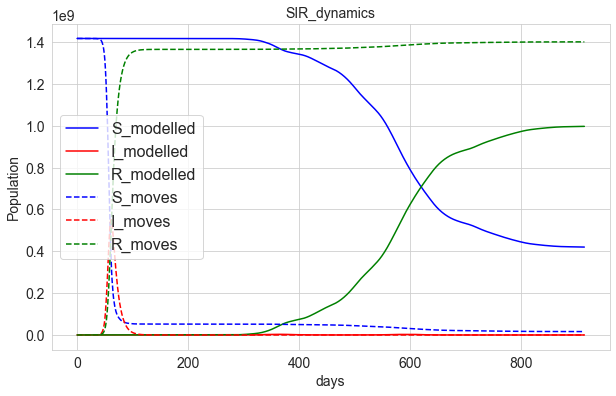

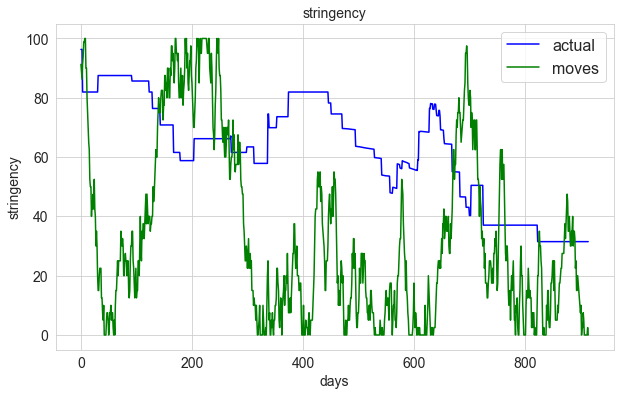

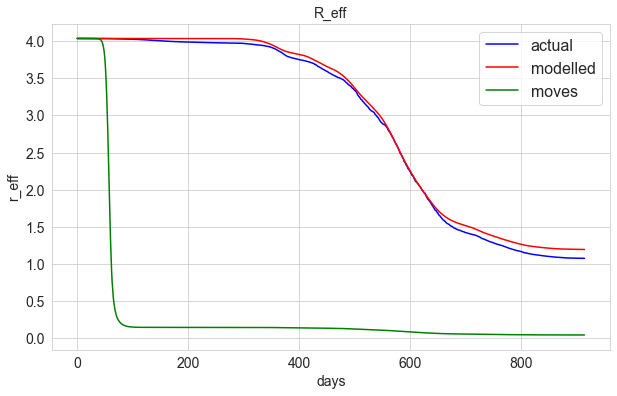

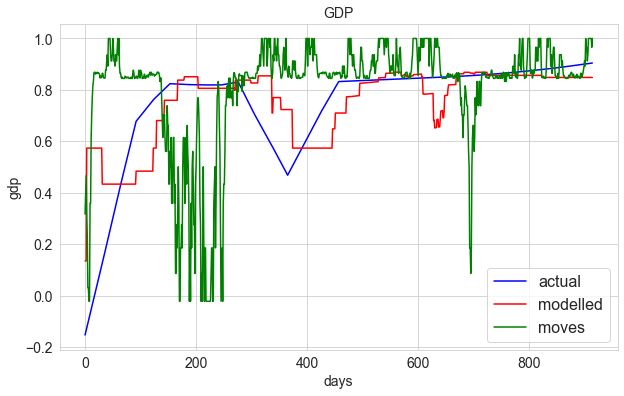

LENS:  915 915


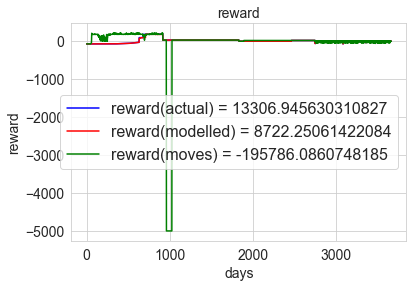

In [22]:
rl_reward_moves, rl_reward_weighted, rl_reward_I_percentage, rl_reward_r_eff, rl_reward_inertia = reward_strategy(stringency_index_from_actions_taken, reward_strategy_choosen=3, sir_technique=1)

In [23]:
info_saved_df = pd.read_csv("output/info_save/-198030.09.csv")
for i in range(0, 914):
    if (rl_reward_inertia[i] != info_saved_df.iloc[i]['reward_inertia']):
        print(rl_reward_inertia[i], info_saved_df.iloc[i]['reward_inertia'], i)

0 -25.0 0
-6.000000000000014 -12.5 7
-0.0 -50.0 8
-0.0 -50.0 43
-0.0 -50.0 44
-0.0 -50.0 45
-25.0 -50.0 50
-12.5 -25.0 59
-25.0 -50.0 61
-37.5 -50.0 209
-12.5 -25.0 211
-25.0 -50.0 218
-0.0 -12.5 219
-0.0 -25.0 221
-0.0 -25.0 224
-0.0 -25.0 226
-37.5 -50.0 245
-25.0 -50.0 248
-25.0 -50.0 318
-0.0 -50.0 324
-0.0 -50.0 325
-0.0 -50.0 327
-0.0 -50.0 331
-12.5 -50.0 334
-37.5 -50.0 341
-0.0 -25.0 342
-12.5 -50.0 347
-37.5 -50.0 362
-37.5 -50.0 398
-0.0 -12.5 399
-0.0 -25.0 400
-0.0 -50.0 403
-0.0 -12.5 404
-12.5 -25.0 409
-12.5 -50.0 413
-0.0 -25.0 476
-25.0 -50.0 478
-0.0 -25.0 479
-12.5 -25.0 529
-0.0 -25.0 533
-0.0 -12.5 535
-0.0 -50.0 537
-0.0 -12.5 538
-0.0 -12.5 542
-12.5 -50.0 544
-0.0 -25.0 546
-37.5 -50.0 561
-0.0 -12.5 594
-0.0 -25.0 595
-0.0 -25.0 596
-0.0 -25.0 597
-25.0 -50.0 605
-12.5 -25.0 609
-12.5 -50.0 611
-0.0 -12.5 612
-0.0 -50.0 615
-0.0 -25.0 616
-0.0 -50.0 617
-0.0 -50.0 618
-0.0 -25.0 619
-0.0 -50.0 622
-0.0 -50.0 623
-25.0 -50.0 630
-12.5 -25.0 634
-25.0 -50.0 783


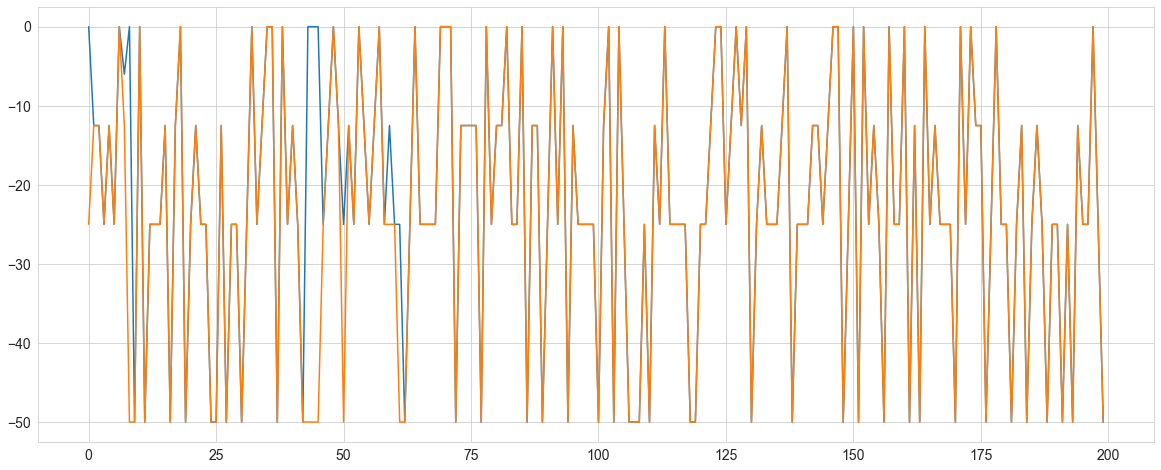

In [24]:
plt.figure(figsize=(20, 8))
plt.plot(rl_reward_inertia[:200])
plt.plot(info_saved_df['reward_inertia'][:200])

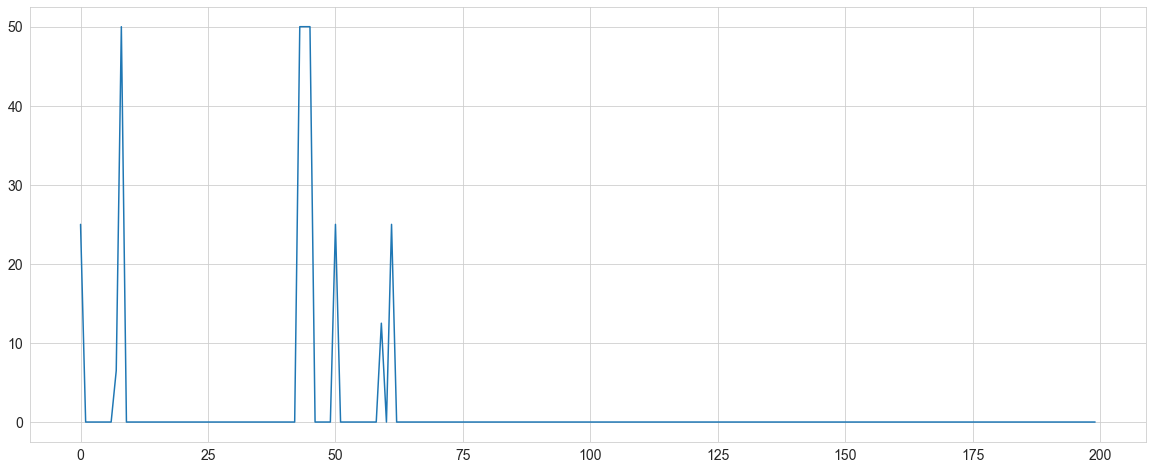

In [25]:
plt.figure(figsize=(20, 8))
plt.plot(rl_reward_inertia[:200] - info_saved_df['reward_inertia'][:200])

In [65]:
for i in range(0, 914):
    if (stringency_index_from_actions_taken[i] != info_saved_df.iloc[i]['stringency_index']):
        print(stringency_index_from_actions_taken[i], info_saved_df.iloc[i]['stringency_index'], i)

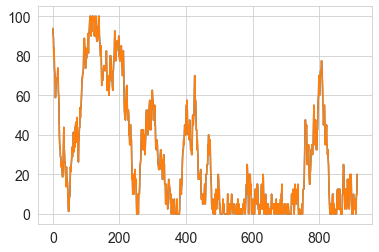

In [66]:
plt.plot(stringency_index_from_actions_taken)
plt.plot(info_saved_df['stringency_index'])

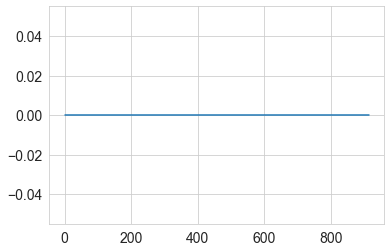

In [67]:
plt.plot(stringency_index_from_actions_taken - info_saved_df['stringency_index'])

inside_rl: 7970 outside_rl: 7970


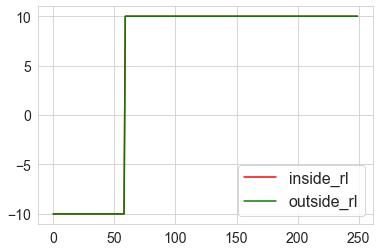

In [68]:
print("inside_rl:", np.sum(info_saved_df['reward_r_eff']), "outside_rl:",  np.sum(rl_reward_r_eff))
plt.plot(info_saved_df['reward_r_eff'][:250], 'r', label='inside_rl')
plt.plot(rl_reward_r_eff[:250], 'g', label='outside_rl')
plt.legend()

inside_rl: -333100 outside_rl: -333100


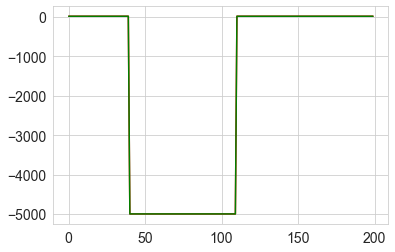

In [69]:
print("inside_rl:", np.sum(info_saved_df['reward_I_percentage']), "outside_rl:", np.sum(rl_reward_I_percentage))
plt.plot(info_saved_df['reward_I_percentage'][:200], 'r', label='inside_rl')
plt.plot(rl_reward_I_percentage[:200], 'g', label='outside_rl')

inside_rl: 140856.492674103 outside_rl: 140856.4926533781


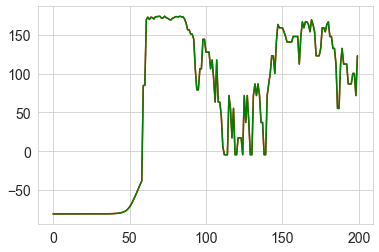

In [70]:
print("inside_rl:", np.sum(info_saved_df['reward_weigthed']), "outside_rl:", np.sum(rl_reward_weighted))
plt.plot(info_saved_df['reward_weigthed'][:200], 'r', label='inside_rl')
plt.plot(rl_reward_weighted[:200], 'g', label='outside_rl')